In this notebook, we repeat the shape transfer experiment in Kale flow code. The code in the Kale gradient descent section is taken directly from theirs.

In [42]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
plt.rcParams['xtick.labelsize'] = 23  
plt.rcParams['ytick.labelsize'] = 23  
plt.rcParams['legend.fontsize'] = 23  
plt.rcParams['axes.labelsize'] = 23    
plt.rcParams['axes.titlesize'] = 23 

# Kale gradient descent

In [44]:
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.gradient_flow import gradient_flow
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kernels import gaussian_kernel
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation

In [45]:
import logging

from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.config import LOG_LEVELS
LOG_LEVELS['gradient_flow'] = logging.INFO

In [46]:
results = {}

In [47]:
from PIL import Image
def _load_img(fn='images/heart.png', size=200, max_samples=None):
    r"""Returns x,y of black pixels (between -1 and 1)
    """
    pic = np.array(Image.open(fn).resize((size,size)).convert('L'))
    y_inv, x = np.nonzero(pic<=128)
    y = size - y_inv - 1
    if max_samples and x.size > max_samples:
        ixsel = np.random.choice(x.size, max_samples, replace=False)
        x, y = x[ixsel], y[ixsel]
    return np.stack((x, y), 1) / size * 2 - 1

def _get_shapes_data():
    rs = np.random.RandomState(42)
    X = _load_img('images/spiral3d.jpg')
    X = X[rs.choice(len(X), 500, replace=False)]

    Y = _load_img('images/heart.png')
    Y = Y[rs.choice(len(Y), 500, replace=False)]

    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float()
    Y.requires_grad = True
    return X, Y

# KALE Flow

In [48]:
_gf_default_kwargs = dict(
    # max_iter=100,
    random_seed=20,
    noise_level_callback=lambda x: 1e-20,
    num_noisy_averages=1,
    generator=_get_shapes_data,
    generator_kwargs=dict(),
    kernel=gaussian_kernel,
    kernel_kwargs={'sigma': 0.01},
    loss=kale_penalized,
    loss_first_variation=kale_penalized_first_variation
)

_kale_default_kwargs={
    "inner_max_iter": 800,
    "inner_tol": 1e-8,
    "inner_a": 0.4,
    "inner_b": 0.8,
    "inplace": False,
    "input_check":True,
    "dual_gap_tol": 5e-2,
    # "optimization_method":"newton",
    "optimization_method":"cd", "optimizer_kwargs": {"dual_gap_tol": 5e-2, "buffer_size": 1000, "max_iter": 20}, "online": True,
}

In [49]:
import time 
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation

for max_iter, lr, _lambda_, exp_name in zip([100, 100], [0.001, 1], [0.001, 10000], ['kale_0001', 'kale_10000']):
    # _lambda_ = 10000 amounts to MMD
    X, Y = _get_shapes_data()
    t0 = time.time()
    args, (X, Y), (trajectories, records, loss_states) = gradient_flow(max_iter=max_iter, lr=lr, loss_kwargs={"lambda_": _lambda_, **_kale_default_kwargs}, **_gf_default_kwargs)
    print(f'total time {time.time() - t0:.3f}s')
    results[exp_name] = {'args': args, 'X': X, 'Y': Y, 'trajectories': trajectories, 'records': records, 'loss_states': loss_states }

 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: loss: 3.18e+00 grad_norm: 2.28e+03
 gradient_flow: loss: 4.37e-01 grad_norm: 3.14e+02
 gradient_flow: loss: 3.88e-01 grad_norm: 2.46e+02
 gradient_flow: loss: 3.70e-01 grad_norm: 2.13e+02
 gradient_flow: loss: 3.81e-01 grad_norm: 3.02e+02
 gradient_flow: loss: 3.35e-01 grad_norm: 2.08e+02
 gradient_flow: loss: 3.31e-01 grad_norm: 2.78e+02
 gradient_flow: loss: 3.30e-01 grad_norm: 2.17e+02
 gradient_flow: loss: 2.98e-01 grad_norm: 2.14e+02
 gradient_flow: loss: 3.18e-01 grad_norm: 2.34e+02
 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: loss: 8.25e-03 grad_norm: 2.36e+00


total time 7.804s


 gradient_flow: loss: 2.75e-03 grad_norm: 1.58e+00
 gradient_flow: loss: 1.80e-03 grad_norm: 1.31e+00
 gradient_flow: loss: 1.36e-03 grad_norm: 1.28e+00
 gradient_flow: loss: 1.29e-03 grad_norm: 1.29e+00
 gradient_flow: loss: 1.14e-03 grad_norm: 1.26e+00
 gradient_flow: loss: 9.71e-04 grad_norm: 1.14e+00
 gradient_flow: loss: 9.90e-04 grad_norm: 1.12e+00
 gradient_flow: loss: 1.11e-03 grad_norm: 1.20e+00
 gradient_flow: loss: 1.00e-03 grad_norm: 1.18e+00


total time 4.917s


In [14]:
name = 'kale_shape_transfer.npy'
print(name)
np.save('save_data/shape_transfer/'+name, results["kale_0001"]['trajectories'])

name = 'mmd_shape_transfer.npy'
print(name)
np.save('save_data/shape_transfer/'+name, results["kale_10000"]['trajectories'])

kale_shape_transfer.npy
mmd_shape_transfer.npy


# KKL Flow

In [1]:
import kkl.divergences as dv
import kkl.kernels as kl
import kkl.generate_data as gy 
import kkl.gradient_descent as gd
import matplotlib.pyplot as plt


In [18]:
## PARAMETERS KKL ##
alpha = 0.01

## KERNEL ###
sigma = 0.15
k = lambda x,y :  kl.k_gauss(x,y,sigma)
dk = lambda x,y : kl.dk_gauss(x, y,sigma)

##DATA##
y,x = _get_shapes_data()
x = x.detach().numpy()
y = y.detach().numpy()
n = len(x)
m = len(y)


###### Ky ####
Ky = 1/m * k(y,y) 

In [20]:
import time

##############################
######## PARAMETERS ##########
##############################

T = 100 # nombre d'itérations
h = 0.005 # stepsize gradient descent
eps = 0.0001
alpha = 0.001

x0 = x
J = lambda x : dv.KKL(x, y, k, Ky, alpha) 
dJ = lambda x : dv.WGrad_KKL(x, y, k, dk, Ky, alpha, sigma) 

t0 = time.time()
positions = gd.gradient_descent(J, dJ, x0, h, eps, T)
print("total time : " + str(time.time()-t0))

name_X = 'kkl_shape_transfer_alpha_'+str(alpha)+'_particles.npy'
np.save('save_data/shape_transfer/'+name_X, position)

total time : 1051.1692550182343


In [50]:
X_0_001 = np.load('save_data/shape_transfer/kkl_shape_transfer_alpha_'+str(0.001)+'_particles.npy')

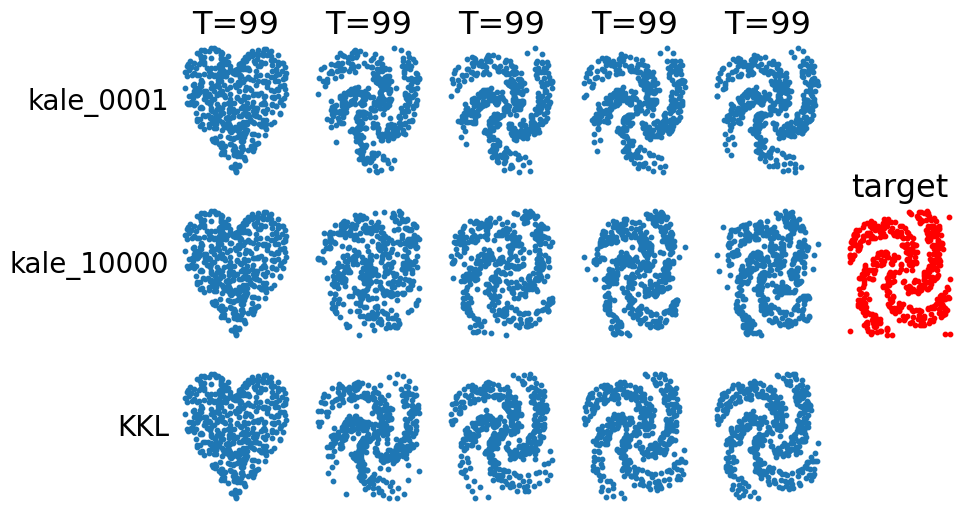

In [52]:
iter_nos = [0, 10, 30, 60, 99]

f, axs = plt.subplots(nrows=len(results)+1, ncols=len(iter_nos)+1, figsize=(5 * len(results), len(iter_nos)+1))

X, Y = _get_shapes_data()   

for (loss_name, result), axs_row in zip(results.items(), axs[:2]):
    for ax, iter_no in zip(axs_row, iter_nos):
        if iter_no == 0:
             ax.scatter(Y.detach().numpy()[:, 0], Y.detach().numpy()[:, 1], s=10)
        else:
            ax.scatter(result['trajectories'][iter_no][:, 0], result['trajectories'][iter_no][:, 1], s=10)
        ax.axis('off')
    axs_row[0].text(x=-0.1, y=0.5, s=loss_name, transform=axs_row[0].transAxes, horizontalalignment='right',fontsize = 20)
    axs_row[-1].axis('off')
for ax,iter_no in zip(axs[2],iter_nos):
        ax.scatter(X_0_001[iter_no,:,0],X_0_001[iter_no,:,1],s=10)
        ax.axis('off')
axs[2][0].text(x=-0.1, y=0.5, s="KKL", transform=axs[2][0].transAxes, horizontalalignment='right',fontsize = 20)
axs[2][-1].axis('off')
for ax in axs[0,:-1]:
    ax.set_title(f'T={iter_no}')
    
axs[len(axs) // 2][-1].scatter(result['X'][:, 0], result['X'][:, 1], s=10, color='red')
axs[len(axs) // 2][-1].set_title('target')
plt.savefig('plots_neurips/shape_transfer/shape_transfer.pdf',dpi = 300,bbox_inches='tight')